# Example of reading and plotting CloudSat radar reflectivity data

Import standard scientific packages

In [1]:
import copy
from pathlib import Path  # object-oriented file paths

import cartopy.crs as ccrs  # for plotting in cartographic projection
import matplotlib as mpl
import matplotlib.pyplot as plt  # the plotting interface
import numpy as np  # for numerical array computations

Also import local modules for reading CloudSat data and interpolating them to a regular grid

In [2]:
import utils
from cloudsat_read import get_geodata, read_data

Define the input directory by creating a `Path`-like object pointing to the local `data/` directory

In [3]:
input_dir = Path("data")

Define a path to the input file

In [4]:
fname = input_dir / "2013085084411_36761_CS_2B-GEOPROF_GRANULE_P_R04_E06.h5"

Read geo data of the CloudSat pass from the input file using the function from the `cloudsat_read.py` script:
* longitude
* latitude
* height
* time
* surface elevation

## Reading data

In [5]:
cloudsat_lons, cloudsat_lats, cloudsat_height, cloudsat_time, elev = get_geodata(
    fname, return_list=True
)
elev = elev * 1e-3

Print out time array

In [6]:
cloudsat_time

array([datetime.datetime(2013, 3, 26, 9, 11, 41),
       datetime.datetime(2013, 3, 26, 9, 11, 41, 160000),
       datetime.datetime(2013, 3, 26, 9, 11, 41, 320000), ...,
       datetime.datetime(2013, 3, 26, 10, 6, 45, 959961),
       datetime.datetime(2013, 3, 26, 10, 6, 46, 120117),
       datetime.datetime(2013, 3, 26, 10, 6, 46, 280029)], dtype=object)

Read radar reflectivity data, to be plotted later

In [7]:
cldst_radar = read_data(fname)

## Creating simple plots

Using `matplotlib` and `cartopy`, create a simple map and plot the CloudSat track

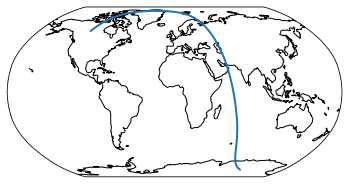

In [8]:
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

ax.plot(cloudsat_lons, cloudsat_lats, linewidth=2, transform=ccrs.PlateCarree());

Similarly, create another plot with a different projection and limited domain

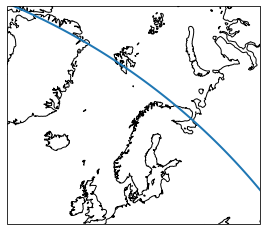

In [9]:
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.Stereographic())
ax.coastlines()
ax.set_extent([-30, 50, 50, 85], crs=ccrs.PlateCarree())

ax.plot(cloudsat_lons, cloudsat_lats, linewidth=2, transform=ccrs.PlateCarree());

## Subsetting data

Define a bounding box - a tuple of `(lon0, lon1, lat0, lat0)` - to select a subset of CloudSat data

In [10]:
bbox = (-2.5, 10, 71, 80)

Find array indices of those longitude and latitude values of CloudSat track that fall within the bounding box

In [11]:
ii = np.where(
    (cloudsat_lons > bbox[0])
    & (cloudsat_lons < bbox[1])
    & (cloudsat_lats > bbox[2])
    & (cloudsat_lats < bbox[3])
)[0]
i1, i2 = ii[0], ii[-1]

Print out the first and the last index of that part of the track

In [12]:
i1, i2

(16748, 16917)

Use this indices to define grid in horizontal

In [13]:
cloudsat_x = np.arange(i1, i2, dtype=np.float32)

Define the **target** vertical grid: from `cloudsat_z0` to `cloudsat_z1` (in kilometres), `cloudsat_nz` levels.

In [14]:
cloudsat_z0 = 0  # km
cloudsat_z1 = 6  # km
cloudsat_nz = 500  # Number of pixels (levels) in the vertical.
# cloudsat_z = np.linspace(cloudsat_z0, cloudsat_z1, cloudsat_nz)

Create another variable, which is just the original `cloudsat_height` array scaled to kilometres

In [15]:
cloudsat_z = (cloudsat_height * 0.001).astype(np.float32)

Select a subset of the radar reflectivity array (note the indices order!)

In [16]:
cldst_radar = cldst_radar[i1:i2, :]

Intepolate radar reflectivity to regular height levels

In [17]:
cldst_radar = utils.cc_interp2d(
    cldst_radar.filled(np.nan),
    cloudsat_x,
    cloudsat_z,
    i1,
    i2,
    i2 - i1,
    cloudsat_z1,
    cloudsat_z0,
    cloudsat_nz,
).T[::-1, :]

## Plotting radar data

Select a colourmap and normalise it to show desired contour levels

In [18]:
radr_cmap = copy.copy(mpl.cm.magma_r)
radr_cmap.set_bad("w")
radr_cmap.set_under("w")
radr_norm = mpl.colors.BoundaryNorm(np.linspace(-20, 30, 6), radr_cmap.N)

Pack all the necessary keywords into a dictionary for convenience

In [19]:
radr_kw = dict(cmap=radr_cmap, norm=radr_norm, rasterized=True, shading="auto")

Create axes and use pseudocolour-mesh method to plot the interpolated radar reflectivity

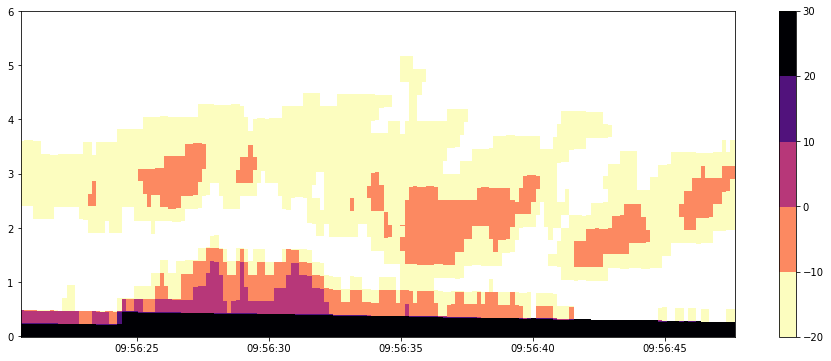

In [20]:
fig, ax = plt.subplots(figsize=(16, 6))
p = ax.pcolormesh(
    cloudsat_time[i1:i2],
    np.linspace(cloudsat_z0, cloudsat_z1, cloudsat_nz),
    cldst_radar,
    **radr_kw
)
fig.colorbar(p);

In [21]:
# class CloudSat:
#     """
#     Handler for reading CloudSat data
#     """
#     def __init__():
#         pass